# Store the running state avg, variance first then random mask training

In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')

In [2]:
class adversial_env(object):
    def __init__(self,runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        self.mask = np.random.choice([1],size = [1,5])
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        if self.epi_num%300 == 299:
            self.mask = np.random.choice([1],size = [1,5])
            self.mask[0,np.random.randint(0,4, size=1)[0]] = 0 
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*self.mask)[0]
        
        
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.mask = np.random.choice([1],size = [1,5])
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# performance in adversarial env without observer

In [3]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-02-15 03:57:50,957] Making new env: RoboschoolInvertedPendulum-v1


430.0 [430.0] [431]


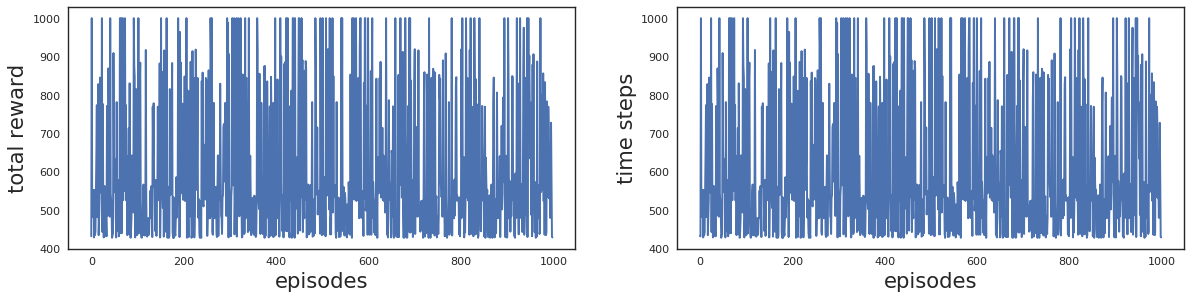

In [4]:
env.result_plot()

# define an observer (new agent)

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.learn()
agn.save_model('agent_model/random_period_mask_observer')

[2018-02-15 03:59:47,010] Making new env: RoboschoolInvertedPendulum-v1


17.0 [17.0] [18]
Episode 0	Last reward: 43.0	Average reward 22.54
('lagrange multiplier:', 1.0203919011567082, 'grad_norm:', 0.14182866389271787)
fval before 2.9540652706768805e-15
a/e/r 0.020418763878247568 0.02040783802313415 1.0005353754327644
fval after -0.020418763878244615
Episode 1	Last reward: 40.0	Average reward 28.11
('lagrange multiplier:', 1.450945386361783, 'grad_norm:', 0.20119024562603566)
fval before -2.570898312040436e-15
a/e/r 0.03172673881793845 0.02901890772723582 1.0933126469181742
fval after -0.031726738817941025
Episode 2	Last reward: 64.0	Average reward 38.55
('lagrange multiplier:', 1.4613660756170377, 'grad_norm:', 0.2170682379418223)
fval before 2.7328540264228746e-15
a/e/r 0.0315839923872142 0.02922732151234185 1.0806324614411622
fval after -0.03158399238721147
Episode 3	Last reward: 52.0	Average reward 60.40
('lagrange multiplier:', 1.4485332271252094, 'grad_norm:', 0.22993701633888078)
fval before 5.020488774116418e-15
a/e/r 0.030314313628196518 0.02897066

In [6]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 880
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_period_mask_observer')

[2018-02-15 04:10:48,832] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [7]:
agn.learn(run_state_update = False)

376.0 [376.0] [377]
Episode 0	Last reward: 317.0	Average reward 586.47
('lagrange multiplier:', 0.40069645668170073, 'grad_norm:', 0.05809267658603031)
fval before 6.020862116255706e-16
a/e/r 0.007630143084618235 0.00801393033475497 0.9521099842268009
fval after -0.007630143084617633
Episode 1	Last reward: 1000.0	Average reward 629.34
('lagrange multiplier:', 0.27790612927781605, 'grad_norm:', 0.051102787890882864)
fval before 3.006375350796765e-16
a/e/r 0.005555779126261267 0.005558122602267195 0.9995783691412328
fval after -0.005555779126260966
Episode 2	Last reward: 1000.0	Average reward 680.19
('lagrange multiplier:', 0.39603677644716045, 'grad_norm:', 0.07583960299545382)
fval before -8.561691286973035e-17
a/e/r 0.0076887758536145255 0.00792073560838924 0.9707148721731055
fval after -0.007688775853614611
Episode 3	Last reward: 1000.0	Average reward 792.97
('lagrange multiplier:', 0.4657182385279574, 'grad_norm:', 0.11550452178150136)
fval before -2.657359827532355e-16
a/e/r 0.0079

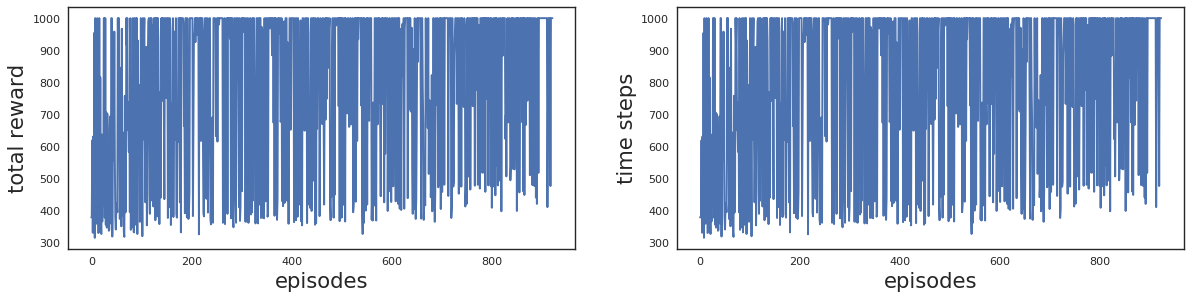

In [8]:
env.result_plot()

# Agent evaluation

In [9]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-02-15 04:27:24,293] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


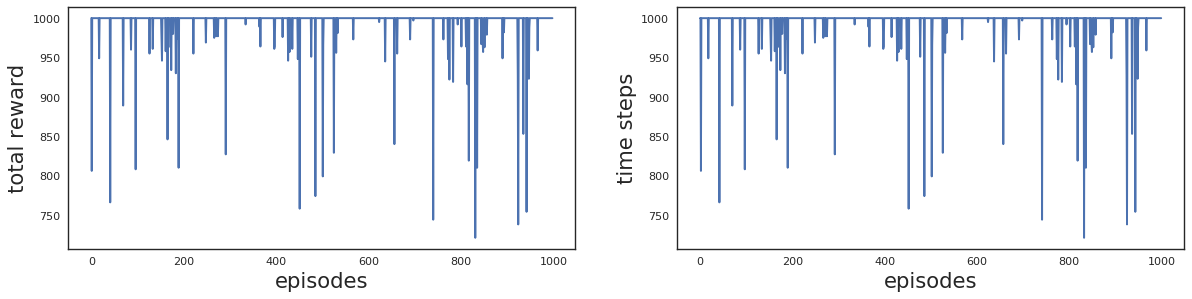

In [10]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [11]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-02-15 04:38:17,345] Making new env: RoboschoolInvertedPendulum-v1


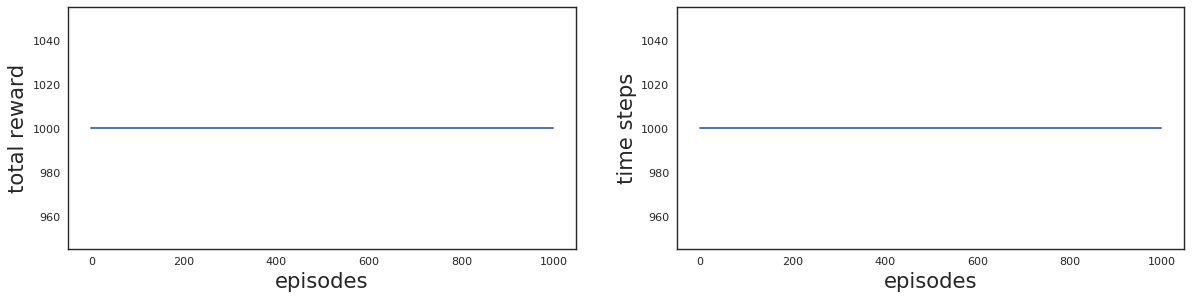

In [12]:
env.result_plot()

# Save model

In [13]:
agn.save_model('agent_model/random_period_mask_observer')